# Transfer Learning DenseNet201 Pre-trained model TL_DN_M0



## 1. Importing and loading the preprocessed dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


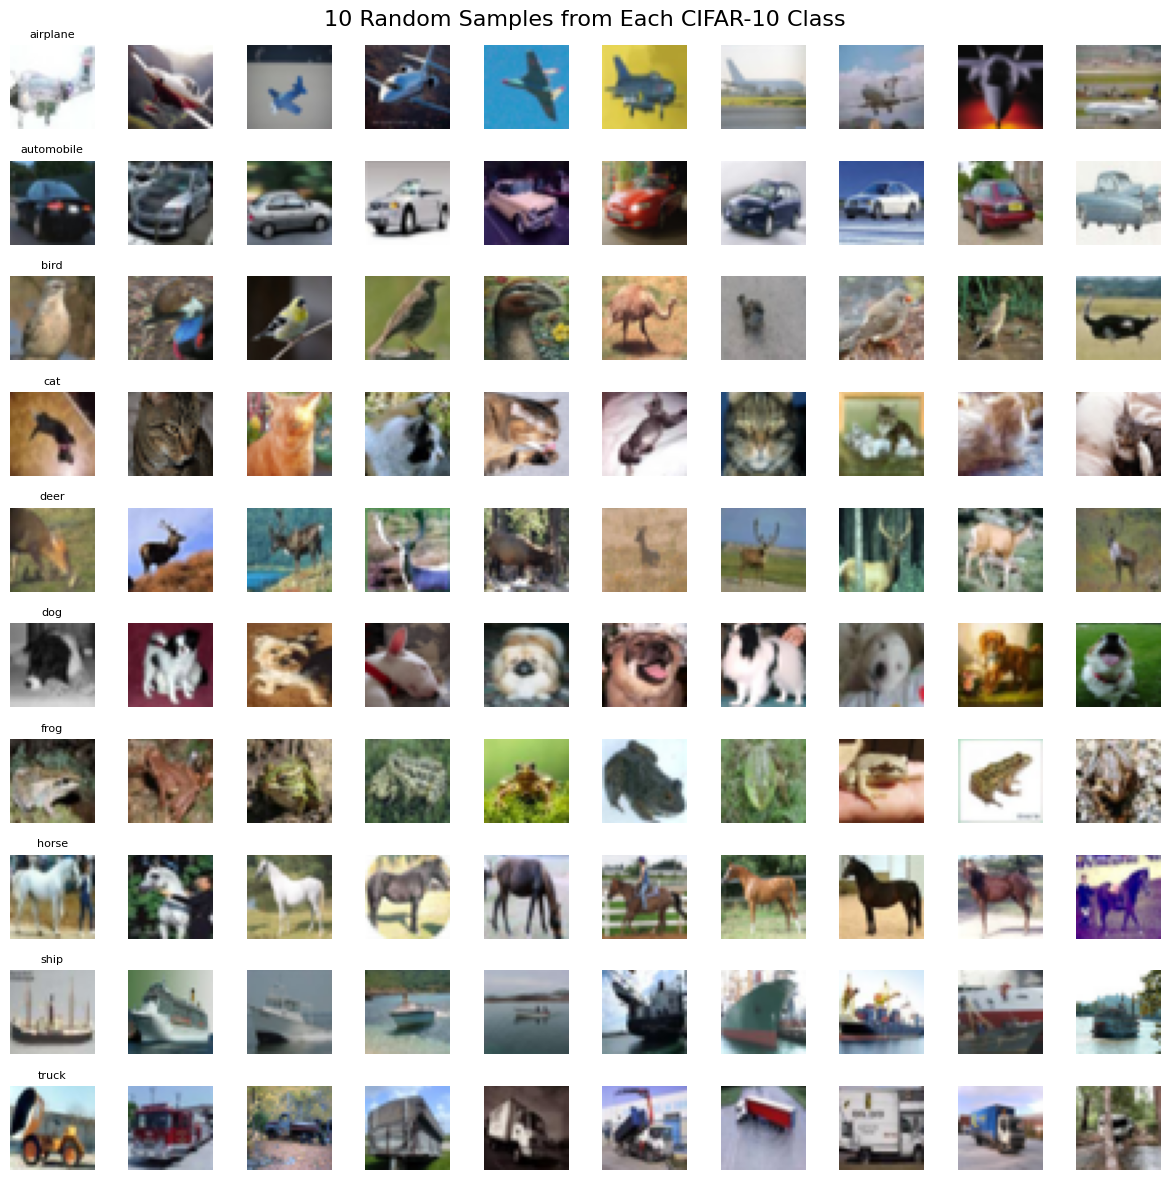

In [3]:
import nbformat
from IPython.core.interactiveshell import InteractiveShell

with open('preprocessing.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

shell = InteractiveShell.instance()
for cell in nb.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

 ## 2. Model building

In [4]:
# First we will clear the keras session
from keras.backend import clear_session
clear_session()


#### 2.1 Loading the DenseNet201 pre-trained model from Keras

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models

# Load DenseNet201, excluding the top (classification) layers
base_model = DenseNet201(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = True  # Freeze the pretrained weights initially

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal")])

In [7]:
# Apply augmentation only to the training dataset
def augment_image(image, label):
    image = data_augmentation(image, training=True) # Apply augmentation during training
    return image, label

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
]

#### 2.2 Creating training and testing datasets, for which we can apply image resizing

In [9]:
import tensorflow as tf
# Setting image size to the input  shape of DenseNet201, so that we can re-size the images from CIFAR-10 data set.
IMG_SIZE = 224

# Create a tf.data.Dataset from our training and testing data
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define a function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# Apply the resizing function to the datasets, we've created
train_ds = train_ds.map(resize_image)
test_ds = test_ds.map(resize_image)

# We define the batch_size we want to use when fitting the model. Alos, we use 'prefetch' method to speed up the training process.
batch_size = 128
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Freeze only the first N layers
N = 160  # We will freeze the first 160 layers, from the 201 that the base model has in total
for layer in base_model.layers[:N]:
    layer.trainable = False
for layer in base_model.layers[N:]:
    layer.trainable = True

In [11]:
train_ds_augmented = train_ds.map(augment_image)

#### 2.3 Defining model architecture

In [ ]:

from tensorflow.keras import regularizers

model = models.Sequential([
    base_model,                                      # Pretrained feature extractor
    layers.GlobalAveragePooling2D(),                 # Reduce tensor shape
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),            # Custom dense layer
    layers.Dropout(0.5),                             # Regularization
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),            # Custom dense layer
    layers.Dropout(0.5),                             # Regularization
    layers.Dense(10, activation='softmax')           # Output layer (adjust to your # of classes)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,847,946 (71.90 MB)

 Trainable params: 17,002,442 (64.86 MB)

 Non-trainable params: 1,845,504 (7.04 MB)

For this model, we have used GlobalAveragePooling2D. Despite MaxPooling2D is great for downsampling and feature selection within the convolutional layers, GlobalAveragePooling2D is often preferred as the final pooling layer before classification because it provides a more robust and parameter-efficient way to summarize the extracted features across the entire image, reducing the risk of overfitting.

## 3. Model training

#### 3.1 Compiling the model

In [ ]:

# Defining batch size and nº of epochs and compiling the model using the defined parameters:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train only the new classification head
history = model.fit(train_ds_augmented, epochs=14, validation_data=test_ds)


Epoch 1/14
391/391 ━━━━━━━━━━━━━━━━━━━━ 917s 1s/step - accuracy: 0.7109 - loss: 1.2684 - val_accuracy: 0.8489 - val_loss: 0.7237
Epoch 2/14
391/391 ━━━━━━━━━━━━━━━━━━━━ 235s 601ms/step - accuracy: 0.8854 - loss: 0.5478 - val_accuracy: 0.8988 - val_loss: 0.4357
Epoch 3/14
391/391 ━━━━━━━━━━━━━━━━━━━━ 235s 600ms/step - accuracy: 0.9183 - loss: 0.3787 - val_accuracy: 0.8717 - val_loss: 0.5678
Epoch 4/14
391/391 ━━━━━━━━━━━━━━━━━━━━ 235s 599ms/step - accuracy: 0.9303 - loss: 0.3043 - val_accuracy: 0.8983 - val_loss: 0.4108
Epoch 5/14
391/391 ━━━━━━━━━━━━━━━━━━━━ 234s 599ms/step - accuracy: 0.9463 - loss: 0.2373 - val_accuracy: 0.9123 - val_loss: 0.3639
Epoch 6/14
391/391 ━━━━━━━━━━━━━━━━━━━━ 234s 598ms/step - accuracy: 0.9530 - loss: 0.2096 - val_accuracy: 0.9075 - val_loss: 0.3702
Epoch 7/14
391/391 ━━━━━━━━━━━━━━━━━━━━ 234s 598ms/step - accuracy: 0.9593 - loss: 0.1811 - val_accuracy: 0.9152 - val_loss: 0.3436
Epoch 8/14
391/391 ━━━━━━━━━━━━━━━━━━━━ 234s 597ms/step - accuracy: 0.9635 - lo

#### 3.2 Fitting the model to the training data

#### 3.3 Plot training history (loss/accuracy curves)

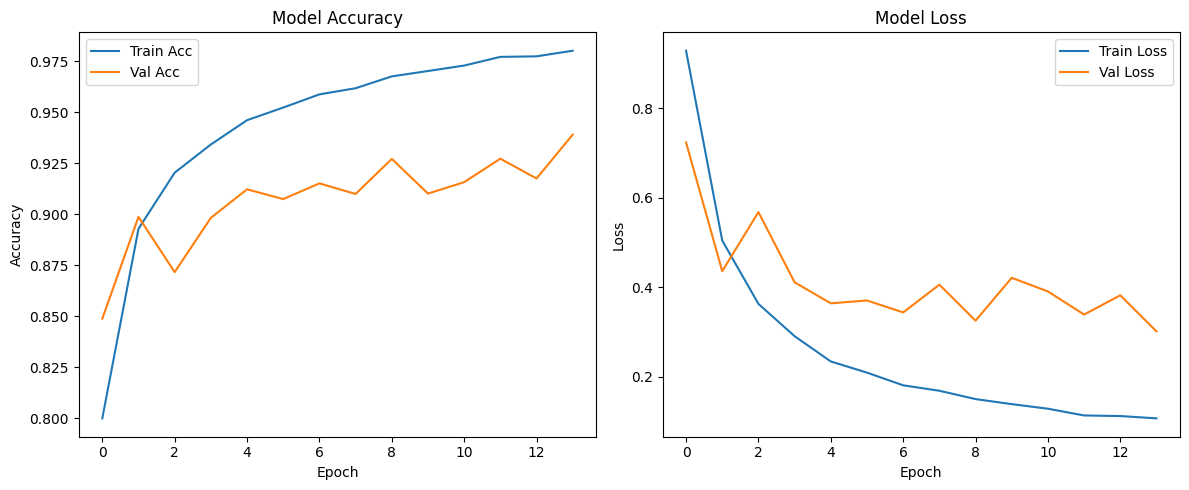

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Model evaluation

#### 4.1 Evaluate on the test set

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.9391
Test loss: 0.3011


#### 4.2 Calculate metrics: Precision, recall, F1 score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Get predictions from the model
y_pred = model.predict(test_ds)

# Convert one-hot encoded labels and predictions to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score, using 'macro' average, as the classes are balanced (6k images per class)
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 465ms/step
Precision: 0.9400
Recall: 0.9391
F1 Score: 0.9393


#### 4.3 Confusion matrix and classification report

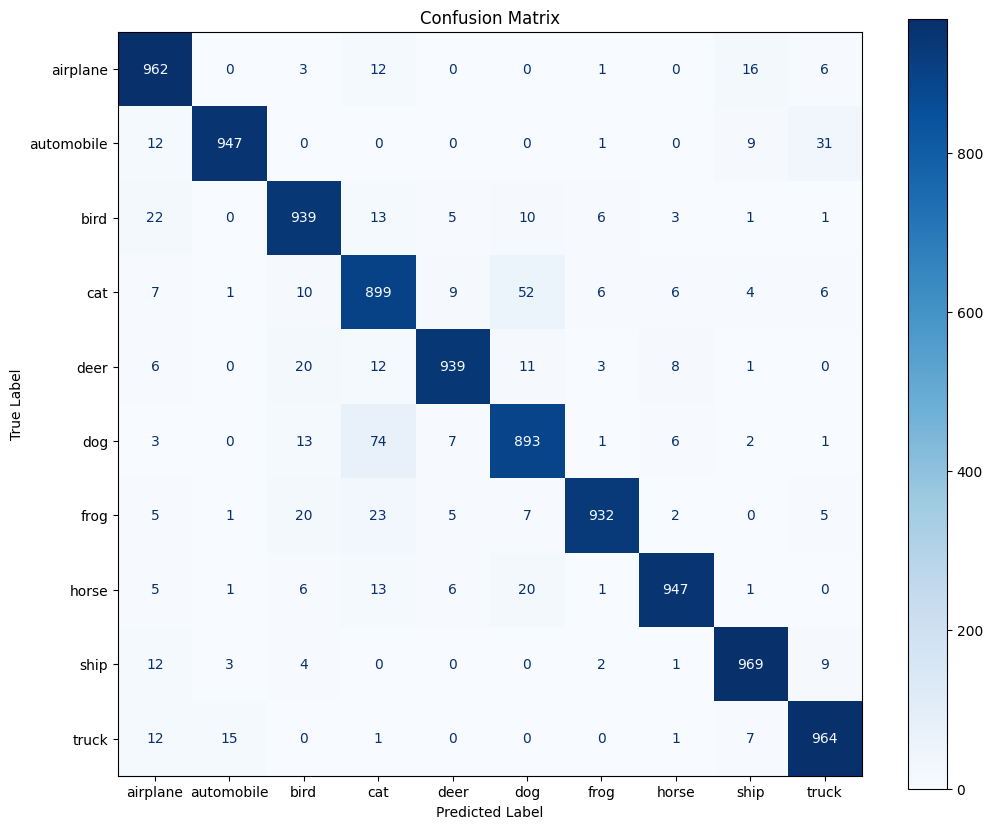

Classification Report:
              precision    recall  f1-score   support

    airplane       0.92      0.96      0.94      1000
  automobile       0.98      0.95      0.96      1000
        bird       0.93      0.94      0.93      1000
         cat       0.86      0.90      0.88      1000
        deer       0.97      0.94      0.95      1000
         dog       0.90      0.89      0.90      1000
        frog       0.98      0.93      0.95      1000
       horse       0.97      0.95      0.96      1000
        ship       0.96      0.97      0.96      1000
       truck       0.94      0.96      0.95      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

## 5. Results and conclusion

We can observe that using a pre-trained model gives very accurate results, eventhough we've just executed 14 epochs. We've achieved an accuracy of 0.9391 and test_loss of 0.3011. This clearly overperforms the models in which we created the CNN from scratch. In this case, we've frozen all the weights from the first 160 layers from the base model, and trained the remaining 41 layers from the base model, plus the 2 dense layers and the output layer we've added on top of it. 

In summary we can define the strengths of our results with the following points: 

- Excellent Performance: The model achieved a test accuracy of 0.9391 and a test loss of 0.3011 after 14 epochs, which is a very strong result for CIFAR-10 classification.
- Transfer Learning Advantage: Leveraging a pre-trained DenseNet201 and fine-tuning only the last 41 layers (while freezing the first 160) allowed the model to benefit from previously learned features, leading to much better results than training a CNN from scratch.
- Efficient Training: High accuracy was reached in relatively few epochs, indicating that the model quickly adapted to the new dataset thanks to the rich feature representations from the pre-trained layers.
- Balanced Generalization: The combination of data augmentation, dropout, and L2 regularization helped the model generalize well, as shown by the low test loss and high accuracy.
- Superior to Custom Models: This approach clearly outperformed previous custom CNNs, confirming that transfer learning with a well-chosen architecture is highly effective for image classification tasks, especially with limited data or computational resources.

In [ ]:
model.save('TL_DN201_M4.keras')